In [359]:
import networkx as nx
import random
import itertools as it
import matplotlib.pyplot as plt

# networkx DiGraph representations of the drawn motifs in motifs.txt.
motifs = {
  "m1": nx.DiGraph([(1,2),(1,3)]),
  "m2": nx.DiGraph([(2,1),(3,1)]),
  "m3": nx.DiGraph([(1,2),(2,3)]),
  "m4": nx.DiGraph([(1,2),(2,3),(3,2)]),
  "m5": nx.DiGraph([(1,2),(1,3),(3,1)]),
  "m6": nx.DiGraph([(1,2),(2,1),(1,3),(3,1)]),
  "m7": nx.DiGraph([(1,2),(1,3),(2,3)]),
  "m8": nx.DiGraph([(1,2),(2,3),(3,1)]),
  "m9": nx.DiGraph([(2,1),(3,1),(2,3),(3,2)]),
  "m10": nx.DiGraph([(1,2),(1,3),(2,3),(3,2)]),
  "m11": nx.DiGraph([(1,2),(2,3),(3,2),(3,1)]),
  "m12": nx.DiGraph([(1,2),(2,1),(1,3),(3,1),(2,3)]),
  "m13": nx.DiGraph([(1,2),(2,1),(1,3),(3,1),(2,3),(3,2)]),
}

In [360]:
# Get input graph.
def get_graph():
  try:
    # Get input graph.
    with open(input('Provide path to graph file: '), 'r') as input_graph:
      G = nx.read_weighted_edgelist(input_graph, create_using=nx.DiGraph, nodetype = int)
    input_graph.close()
    
    return G
  except FileNotFoundError:
    print("FileNotFoundError: Invalid file or directory. Check the file exists and try again.")

# Get motif of interest.
def get_motif():
  motifs = open('./motifs/motifs.txt', 'r')
  motif_prompt = motifs.read()
  
  chosen_motif = input(
    motif_prompt + "\n" +
    "Choose one motif listed above (1 - 13) of which you'll change its frequency: "
  )
  while not chosen_motif.isnumeric() or int(chosen_motif) < 1 or int(chosen_motif) > 13:
    chosen_motif = input(
      motif_prompt + "\n" + "Please enter a number between 1 and 13: "
    )
  
  motifs.close()
  
  return f"m{chosen_motif}"

# Get frequency change (increasing or decreasing).
def get_freq_change():
  freq = input("Increase or decrease frequency of motif? (i or d): ")
  while freq != "i" and freq != "d":
    freq = input("Please enter i or d: ")
    
  return freq

In [361]:
# Check that the given triad could be a motif in graph G.
def connected_triad(G, tri):
  u, v, w = tri[0], tri[1], tri[2]
  uv = G.number_of_edges(u, v) > 0 or G.number_of_edges(v, u) > 0
  vw = G.number_of_edges(v, w) > 0 or G.number_of_edges(w, v) > 0
  uw = G.number_of_edges(u, w) > 0 or G.number_of_edges(w, u) > 0
  
  # Accounts for all triads with 3 edges as well.
  connected = (uv and vw) or (uw and vw) or (uv and uw)
  
  return connected

# Calculate frequency of specified motif in a subgraph of G induced 
# by the specified neighborhood.
def motif_freq(G, motif, neighborhood):
  motif = motifs[motif]
  
  # Get unique triads in the neighborhood.
  triads = it.combinations(neighborhood, 3)
  
  # Filter out triads that aren't connected and thus cannot be motifs.
  triads = [t for t in triads if connected_triad(G, t)]

  freq = 0
  for tri in triads:
    subgraph = G.subgraph(tri)
    if nx.is_isomorphic(subgraph, motif):
      freq += 1
  
  return freq

In [362]:
# Select two random edges from a given edge list.
def random_edges(edges):
  u = random.choice(edges)
  v = random.choice(edges)
  
  # Ensure u and v do not share nodes.
  while u[0] in v or u[1] in v:
    v = random.choice(edges)
  
  return u, v

# Get the neighborhood comprised of the nodes on edges u and v and each of their
# adjacent neighbors (in and out). 
def get_neighborhood(G, u, v):
  u0_neighbors = list(G.successors(u[0])) + list(G.predecessors(u[0]))
  u1_neighbors = list(G.successors(u[1])) + list(G.predecessors(u[1]))
  v0_neighbors = list(G.successors(v[0])) + list(G.predecessors(v[0]))
  v1_neighbors = list(G.successors(v[1])) + list(G.predecessors(v[1]))
  
  neighborhood = set(list(u) + list(v) + u0_neighbors + 
                     u1_neighbors + v0_neighbors + v1_neighbors)
  
  return neighborhood

# Undo a previous edge swap.
def undo_swap(G, u, v):
  G.remove_edge(u[0], v[1])
  G.remove_edge(v[0], u[1])
  
  G.add_edge(u[0], u[1])
  G.add_edge(v[0], v[1])
  
  return G

# Swap two edges in graph G.
def swap_edges(G, motif, freq_change):
  edges = list(G.edges)
  u, v = random_edges(edges)

  # Prevent multi-edge
  while G.has_edge(u[0], v[1]) or G.has_edge(v[0], u[1]):
    u, v = random_edges(edges)
    
  neighborhood = get_neighborhood(G, u, v)
  
  mf_before_swap = motif_freq(G, motif, neighborhood)

  G.remove_edge(u[0], u[1])
  G.remove_edge(v[0], v[1])
  
  G.add_edge(u[0], v[1])
  G.add_edge(v[0], u[1])

  mf_after_swap = motif_freq(G, motif, neighborhood)
  
  # Discard edge swap if motif frequency does not change as desired.
  if (freq_change == "i" and mf_after_swap < mf_before_swap) or \
    (freq_change == "d" and mf_after_swap > mf_before_swap):
      G = undo_swap(G, u, v)
  
  return G


# Randomize graph G using biased link randomization, maintaining degree sequence.
def randomize(G, motif, freq_change):
  # Network parameters
  parameters = {
    "avg_clust": [nx.average_clustering(G)],
    "asst_coef": [nx.degree_pearson_correlation_coefficient(G)],
    "avg_spath": [nx.average_shortest_path_length(G)]
  }
  
  steps = 10 * G.number_of_edges()
  for _ in range(steps):
    G = swap_edges(G, motif, freq_change)
    parameters["avg_clust"].append(nx.average_clustering(G))
    parameters["asst_coef"].append(nx.degree_pearson_correlation_coefficient(G))
    parameters["avg_spath"].append(nx.average_shortest_path_length(G))
  
  return G, parameters

In [363]:
# Return the degree sequence of graph G.
def degree_sequence(G):
  return [d for _, d in G.degree()]

In [364]:
def visualize_parameters(parameters):
  i = 4
  for k, v in parameters.items():
    plt.figure(i)
    plt.plot(v)
    plt.savefig(f"./output/{k}.jpg")
    plt.close()
    i += 1

In [365]:
def main():
  G, motif, freq_change = get_graph(), get_motif(), get_freq_change()

  plt.figure(1)
  plt.hist(list(nx.betweenness_centrality(G).values()))  
  plt.savefig("betweenness.jpg")
  
  plt.figure(2)
  plt.hist(list(nx.closeness_centrality(G).values()))  
  plt.savefig("closeness.jpg")
  
  plt.figure(3)
  plt.hist(list(nx.pagerank(G).values()))
  plt.savefig("pagerank.jpg")
  
  r_G, parameters = randomize(G.copy(), motif, freq_change)
  
  visualize_parameters(parameters)
  # TODO: Visualize the networks themselves, and the change in motif frequency during randomization
  
  print(motif_freq(G, motif, list(G.nodes)), motif_freq(r_G, motif, list(r_G.nodes)))

  # After randomization, compare the number of occurrences of the motif in the 
  # original network with the number of occurrences in the randomized one:
  #   - if there are significantly more of the given motif in the original network, 
  #     we can say that it is "over expressed",
  #   - if there are significantly less of the given motif in the original network, 
  #     we can say that it is "under expressed".
  # More details in slides.

True
11 73


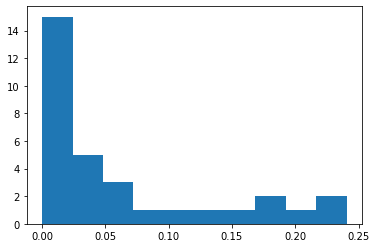

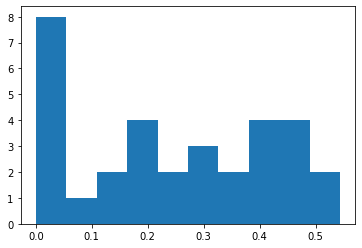

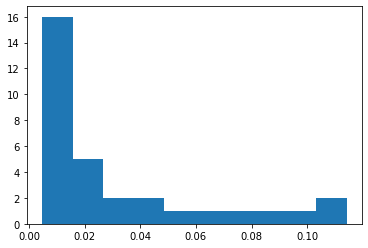

In [366]:
if __name__ == '__main__':
  main()